In [31]:
import pandas as pd
import multiprocessing as mp 
import matplotlib.pyplot as plt
import dask.dataframe as dd
import plotly.express as px
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np



In [46]:
df_2022 = pd.read_pickle('data/MTA_Subway_Hourly_Ridership_2022.pkl')
df_2023 = pd.read_pickle('data/MTA_Subway_Hourly_Ridership_2023.pkl')

# single year
# df_2022 = pd.read_pickle('data/MTA_Subway_Hourly_Ridership_2022.pkl')

In [47]:
# Merger the dataframes
ridership_data_all_years = pd.concat([df_2022, df_2023], axis=0)


In [48]:
#single year
# hourly_ridership_data = df_2022.copy()

# multi year 
hourly_ridership_data = ridership_data_all_years.copy()


In [49]:
hourly_ridership_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48102193 entries, 0 to 25588030
Data columns (total 12 columns):
 #   Column               Dtype         
---  ------               -----         
 0   transit_timestamp    datetime64[ns]
 1   transit_mode         object        
 2   station_complex_id   object        
 3   station_complex      object        
 4   borough              object        
 5   payment_method       object        
 6   fare_class_category  object        
 7   ridership            object        
 8   transfers            object        
 9   latitude             float64       
 10  longitude            float64       
 11  Georeference         object        
dtypes: datetime64[ns](1), float64(2), object(9)
memory usage: 4.7+ GB


In [50]:
# convert ridership to numeric
hourly_ridership_data['ridership'] = pd.to_numeric(hourly_ridership_data['ridership'], errors='coerce')

In [51]:
display(hourly_ridership_data.head())

,transit_timestamp,transit_mode,station_complex_id,station_complex,borough,payment_method,fare_class_category,ridership,transfers,latitude,longitude,Georeference
0,2022-02-17 22:00:00,subway,59,9 Av (D),Brooklyn,omny,OMNY - Full Fare,4.0,0,40.646294,-73.99432,POINT (-73.99432 40.646294)
1,2022-03-10 23:00:00,subway,404,28 St (6),Manhattan,omny,OMNY - Other,1.0,0,40.743070,-73.98426,POINT (-73.98426 40.74307)
2,2022-10-05 21:00:00,subway,272,"36 St (M,R)",Queens,omny,OMNY - Full Fare,14.0,0,40.752040,-73.92878,POINT (-73.92878 40.75204)
3,2022-10-05 22:00:00,subway,420,"219 St (2,5)",Bronx,omny,OMNY - Full Fare,5.0,0,40.883896,-73.86263,POINT (-73.86263 40.883896)
4,2022-10-05 10:00:00,subway,218,"167 St (B,D)",Bronx,omny,OMNY - Full Fare,78.0,6,40.833770,-73.91844,POINT (-73.91844 40.83377)


In [52]:
# get unique stations complex id
station_complex_id = hourly_ridership_data['station_complex_id'].unique()
print(f"Number of unique stations: {len(station_complex_id)}")

Number of unique stations: 854


In [53]:
# group by station complex id
grouped_station_complex = hourly_ridership_data.groupby('station_complex_id')

# get the number of rows for each station complex
station_complex_count = grouped_station_complex.size()
display(station_complex_count)



station_complex_id
1          9903
2         10854
3          3963
4          9382
5           766
          ...  
97       119002
98       116432
99       108431
TRAM1     89220
TRAM2     86742
Length: 854, dtype: int64

In [54]:
# Ensure that day and hour columns are present in the dataset
hourly_ridership_data['day'] = hourly_ridership_data['transit_timestamp'].dt.date
hourly_ridership_data['hour'] = hourly_ridership_data['transit_timestamp'].dt.hour

# group by station_complex, day, and hour and sum of ridership for each
grouped_station_complex_hourly = (
    hourly_ridership_data
    .groupby(['station_complex_id', 'day', 'hour'])['ridership']
    .sum()
    .reset_index()
)

# Display the first few rows to check the result
display(grouped_station_complex_hourly.head(24))


,station_complex_id,day,hour,ridership
0,1,2022-02-19,0,58.0
1,1,2022-02-19,1,24.0
2,1,2022-02-19,2,2.0
3,1,2022-02-19,3,7.0
4,1,2022-02-19,4,18.0
5,1,2022-02-19,5,55.0
6,1,2022-02-19,6,85.0
7,1,2022-02-19,7,21.0
8,1,2022-02-19,8,318.0
9,1,2022-02-19,9,381.0


In [68]:
# total ridershep per day per station
grouped_station_complex_daily = (
    grouped_station_complex_hourly
    .groupby(['station_complex_id', 'day'])['ridership']
    .sum()
    .reset_index()
)

# Display the first few rows to check the result
display(grouped_station_complex_daily.head())
grouped_station_complex_daily.info()


,station_complex_id,day,ridership
0,1,2022-02-19,3791.0
1,1,2022-03-09,9655.0
2,1,2022-03-15,2750.0
3,1,2022-03-19,4539.0
4,1,2022-03-29,9776.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 317467 entries, 0 to 317466
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   station_complex_id  317467 non-null  object 
 1   day                 317467 non-null  object 
 2   ridership           317467 non-null  float64
dtypes: float64(1), object(2)
memory usage: 7.3+ MB


In [69]:
# Convert day to date
grouped_station_complex_daily['day'] = pd.to_datetime(grouped_station_complex_daily['day'])
grouped_station_complex_daily.info()
print(grouped_station_complex_daily.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 317467 entries, 0 to 317466
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   station_complex_id  317467 non-null  object        
 1   day                 317467 non-null  datetime64[ns]
 2   ridership           317467 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 7.3+ MB
  station_complex_id        day  ridership
0                  1 2022-02-19     3791.0
1                  1 2022-03-09     9655.0
2                  1 2022-03-15     2750.0
3                  1 2022-03-19     4539.0
4                  1 2022-03-29     9776.0


In [70]:
# merge weather data with ridership data
weather_data = pd.read_csv('data/Cleaned_data/weather_data_ny_cleaned.csv')
print(weather_data.head())
weather_data.info()

         DATE                         NAME  TMAX  TMIN  TAVG  PRCP  AWND  SNOW
0  2022-01-01  NY CITY CENTRAL PARK, NY US  56.0  50.0  53.0  0.79  3.13   0.0
1  2022-01-02  NY CITY CENTRAL PARK, NY US  59.0  37.0  48.0  0.04  5.82   0.0
2  2022-01-03  NY CITY CENTRAL PARK, NY US  37.0  22.0  29.5  0.00  9.84   0.0
3  2022-01-04  NY CITY CENTRAL PARK, NY US  34.0  19.0  26.5  0.00  6.04   0.0
4  2022-01-05  NY CITY CENTRAL PARK, NY US  47.0  31.0  39.0  0.23  5.59   0.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020 entries, 0 to 1019
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    1020 non-null   object 
 1   NAME    1020 non-null   object 
 2   TMAX    1020 non-null   float64
 3   TMIN    1020 non-null   float64
 4   TAVG    1020 non-null   float64
 5   PRCP    1020 non-null   float64
 6   AWND    1015 non-null   float64
 7   SNOW    1020 non-null   float64
dtypes: float64(6), object(2)
memory usage: 63.9+ 

In [71]:
# Convert date to date 
weather_data['DATE'] = pd.to_datetime(weather_data['DATE'])
print(weather_data.head())
weather_data.info()

        DATE                         NAME  TMAX  TMIN  TAVG  PRCP  AWND  SNOW
0 2022-01-01  NY CITY CENTRAL PARK, NY US  56.0  50.0  53.0  0.79  3.13   0.0
1 2022-01-02  NY CITY CENTRAL PARK, NY US  59.0  37.0  48.0  0.04  5.82   0.0
2 2022-01-03  NY CITY CENTRAL PARK, NY US  37.0  22.0  29.5  0.00  9.84   0.0
3 2022-01-04  NY CITY CENTRAL PARK, NY US  34.0  19.0  26.5  0.00  6.04   0.0
4 2022-01-05  NY CITY CENTRAL PARK, NY US  47.0  31.0  39.0  0.23  5.59   0.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020 entries, 0 to 1019
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    1020 non-null   datetime64[ns]
 1   NAME    1020 non-null   object        
 2   TMAX    1020 non-null   float64       
 3   TMIN    1020 non-null   float64       
 4   TAVG    1020 non-null   float64       
 5   PRCP    1020 non-null   float64       
 6   AWND    1015 non-null   float64       
 7   SNOW    1020 non-null   f

In [74]:
# merging the weather data with the ridership data
merged_data = pd.merge(
    grouped_station_complex_daily,
    weather_data,
    left_on='day',
    right_on='DATE',
    how='inner'
)

# Display the first few rows to check the result
display(merged_data.sample(5))
merged_data.info()

,station_complex_id,day,ridership,DATE,NAME,TMAX,TMIN,TAVG,PRCP,AWND,SNOW
268190,6,2023-05-08,2570.0,2023-05-08,"NY CITY CENTRAL PARK, NY US",77.0,58.0,67.5,0.00,4.70,0.0
48656,138,2023-04-21,2389.0,2023-04-21,"NY CITY CENTRAL PARK, NY US",71.0,51.0,61.0,0.00,5.14,0.0
238780,443,2022-07-22,1621.0,2022-07-22,"NY CITY CENTRAL PARK, NY US",94.0,78.0,86.0,0.00,2.68,0.0
188018,364,2023-03-17,1810.0,2023-03-17,"NY CITY CENTRAL PARK, NY US",60.0,47.0,53.5,0.00,3.36,0.0
175220,348,2022-02-13,939.0,2022-02-13,"NY CITY CENTRAL PARK, NY US",42.0,25.0,33.5,0.23,6.71,1.6


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 317467 entries, 0 to 317466
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   station_complex_id  317467 non-null  object        
 1   day                 317467 non-null  datetime64[ns]
 2   ridership           317467 non-null  float64       
 3   DATE                317467 non-null  datetime64[ns]
 4   NAME                317467 non-null  object        
 5   TMAX                317467 non-null  float64       
 6   TMIN                317467 non-null  float64       
 7   TAVG                317467 non-null  float64       
 8   PRCP                317467 non-null  float64       
 9   AWND                317467 non-null  float64       
 10  SNOW                317467 non-null  float64       
dtypes: datetime64[ns](2), float64(7), object(2)
memory usage: 26.6+ MB


In [75]:
merged_data['temp_range'] = merged_data['TMAX'] - merged_data['TMIN']
merged_data.head()


,station_complex_id,day,ridership,DATE,NAME,TMAX,TMIN,TAVG,PRCP,AWND,SNOW,temp_range
0,1,2022-02-19,3791.0,2022-02-19,"NY CITY CENTRAL PARK, NY US",40.0,23.0,31.5,0.00,8.28,0.0,17.0
1,1,2022-03-09,9655.0,2022-03-09,"NY CITY CENTRAL PARK, NY US",41.0,33.0,37.0,0.56,5.82,0.4,8.0
2,1,2022-03-15,2750.0,2022-03-15,"NY CITY CENTRAL PARK, NY US",68.0,46.0,57.0,0.00,4.92,0.0,22.0
3,1,2022-03-19,4539.0,2022-03-19,"NY CITY CENTRAL PARK, NY US",70.0,49.0,59.5,0.05,2.68,0.0,21.0
4,1,2022-03-29,9776.0,2022-03-29,"NY CITY CENTRAL PARK, NY US",38.0,24.0,31.0,0.00,10.51,0.0,14.0


In [101]:
# feature engineering for weather events
merged_data['is_rainy'] = merged_data['PRCP'].apply(lambda x: 1 if x > 0 else 0)
merged_data['is_snowy'] = merged_data['SNOW'].apply(lambda x: 1 if x > 0 else 0)
merged_data['is_cold'] = merged_data['TAVG'].apply(lambda x: 1 if x < 32 else 0)
merged_data['is_hot'] = merged_data['TAVG'].apply(lambda x: 1 if x > 90 else 0)
merged_data['is_windy'] = merged_data['AWND'].apply(lambda x: 1 if x > 10 else 0)


merged_data.head()


,station_complex_id,day,ridership,DATE,NAME,TMAX,TMIN,TAVG,PRCP,AWND,...,is_rainy,is_snowy,is_cold,is_hot,is_holiday,holiday_name,day_of_week,month,day_name,is_windy
0,1,2022-02-19,3791.0,2022-02-19,"NY CITY CENTRAL PARK, NY US",40.0,23.0,31.5,0.00,8.28,...,0,0,1,0,0,None,5,2,Saturday,0
1,1,2022-03-09,9655.0,2022-03-09,"NY CITY CENTRAL PARK, NY US",41.0,33.0,37.0,0.56,5.82,...,1,1,0,0,0,None,2,3,Wednesday,0
2,1,2022-03-15,2750.0,2022-03-15,"NY CITY CENTRAL PARK, NY US",68.0,46.0,57.0,0.00,4.92,...,0,0,0,0,0,None,1,3,Tuesday,0
3,1,2022-03-19,4539.0,2022-03-19,"NY CITY CENTRAL PARK, NY US",70.0,49.0,59.5,0.05,2.68,...,1,0,0,0,0,None,5,3,Saturday,0
4,1,2022-03-29,9776.0,2022-03-29,"NY CITY CENTRAL PARK, NY US",38.0,24.0,31.0,0.00,10.51,...,0,0,1,0,0,None,1,3,Tuesday,1


In [102]:
# check for hoidays
import holidays
us_holidays = holidays.US()
merged_data['is_holiday'] = merged_data['day'].apply(lambda x: 1 if x in us_holidays else 0)
merged_data['holiday_name'] = merged_data['day'].apply(lambda x: us_holidays.get(x))
display(merged_data[merged_data['is_holiday'] == 1].head())




,station_complex_id,day,ridership,DATE,NAME,TMAX,TMIN,TAVG,PRCP,AWND,...,is_rainy,is_snowy,is_cold,is_hot,is_holiday,holiday_name,day_of_week,month,day_name,is_windy
40,1,2023-02-20,3579.0,2023-02-20,"NY CITY CENTRAL PARK, NY US",61.0,47.0,54.0,0.0,6.04,...,0,0,0,0,1,Washington's Birthday,0,2,Monday,0
121,2,2023-02-20,2691.0,2023-02-20,"NY CITY CENTRAL PARK, NY US",61.0,47.0,54.0,0.0,6.04,...,0,0,0,0,1,Washington's Birthday,0,2,Monday,0
182,3,2023-01-01,21.0,2023-01-01,"NY CITY CENTRAL PARK, NY US",55.0,49.0,52.0,0.0,4.92,...,0,0,0,0,1,New Year's Day,6,1,Sunday,0
253,4,2023-02-20,961.0,2023-02-20,"NY CITY CENTRAL PARK, NY US",61.0,47.0,54.0,0.0,6.04,...,0,0,0,0,1,Washington's Birthday,0,2,Monday,0
437,8,2023-02-20,4074.0,2023-02-20,"NY CITY CENTRAL PARK, NY US",61.0,47.0,54.0,0.0,6.04,...,0,0,0,0,1,Washington's Birthday,0,2,Monday,0


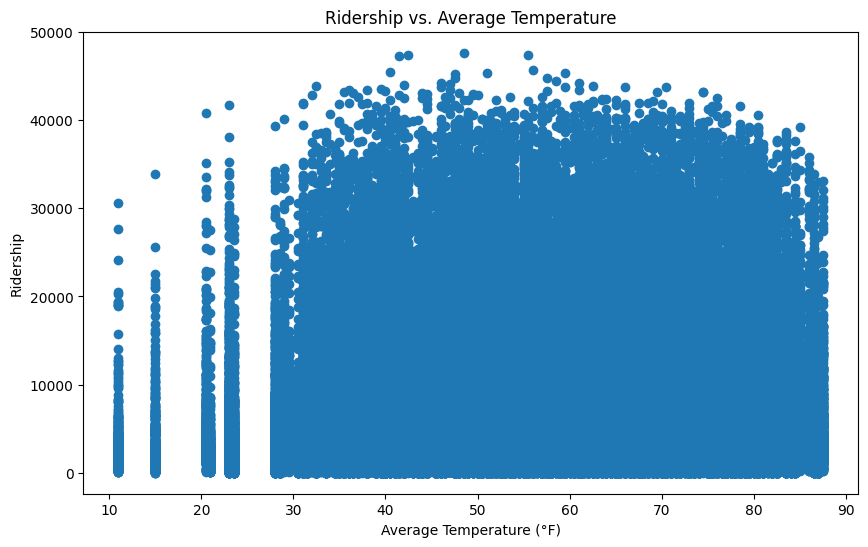

In [103]:
plt.figure(figsize=(10, 6))
plt.scatter(merged_data['TAVG'], merged_data['ridership'])
plt.xlabel('Average Temperature (°F)')
plt.ylabel('Ridership')
plt.title('Ridership vs. Average Temperature')
plt.show()


In [104]:
import seaborn as sns

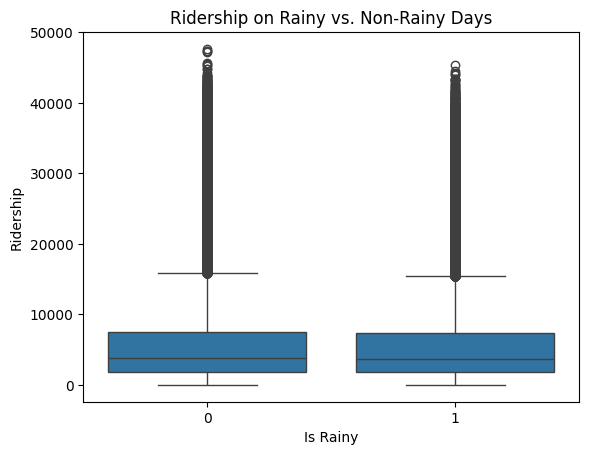

In [105]:
sns.boxplot(x='is_rainy', y='ridership', data=merged_data)
plt.xlabel('Is Rainy')
plt.ylabel('Ridership')
plt.title('Ridership on Rainy vs. Non-Rainy Days')
plt.show()


In [106]:
# day of week, month
merged_data['day_of_week'] = merged_data['day'].dt.dayofweek # Monday is 0 and Sunday is 6
merged_data['day_name'] = merged_data['day'].dt.day_name()
merged_data['month'] = merged_data['day'].dt.month

display(merged_data.head())

,station_complex_id,day,ridership,DATE,NAME,TMAX,TMIN,TAVG,PRCP,AWND,...,is_rainy,is_snowy,is_cold,is_hot,is_holiday,holiday_name,day_of_week,month,day_name,is_windy
0,1,2022-02-19,3791.0,2022-02-19,"NY CITY CENTRAL PARK, NY US",40.0,23.0,31.5,0.00,8.28,...,0,0,1,0,0,None,5,2,Saturday,0
1,1,2022-03-09,9655.0,2022-03-09,"NY CITY CENTRAL PARK, NY US",41.0,33.0,37.0,0.56,5.82,...,1,1,0,0,0,None,2,3,Wednesday,0
2,1,2022-03-15,2750.0,2022-03-15,"NY CITY CENTRAL PARK, NY US",68.0,46.0,57.0,0.00,4.92,...,0,0,0,0,0,None,1,3,Tuesday,0
3,1,2022-03-19,4539.0,2022-03-19,"NY CITY CENTRAL PARK, NY US",70.0,49.0,59.5,0.05,2.68,...,1,0,0,0,0,None,5,3,Saturday,0
4,1,2022-03-29,9776.0,2022-03-29,"NY CITY CENTRAL PARK, NY US",38.0,24.0,31.0,0.00,10.51,...,0,0,1,0,0,None,1,3,Tuesday,1


In [107]:
features = [
    'day_of_week', 'month', 'is_holiday',
    'TAVG', 'temp_range', 'PRCP', 'AWND', 'SNOW',
    'is_rainy', 'is_snowy', 'is_windy', 'is_cold', 'is_hot'
]


In [108]:
X = merged_data[features]
y = merged_data['ridership']


In [109]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)


In [110]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)


In [111]:
from sklearn.metrics import mean_absolute_error

mae_list = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mae_list.append(mae)
    print('MAE:', mae)

print('Average MAE:', np.mean(mae_list))


MAE: 3591.0961734447665
MAE: 3539.7815672370693
MAE: 2708.103911927204
MAE: 3754.138516675971
MAE: 6821.446342242192
Average MAE: 4082.913302305441


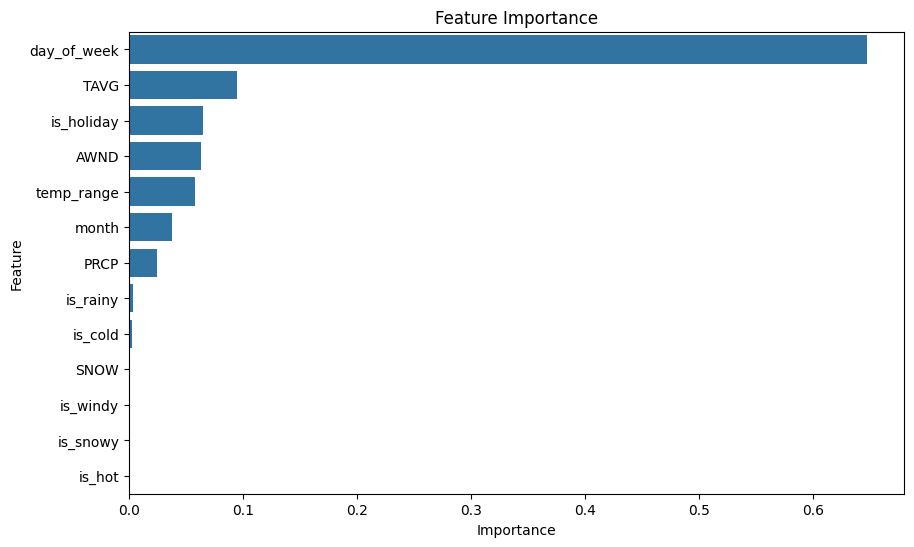

In [112]:
importances = model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()


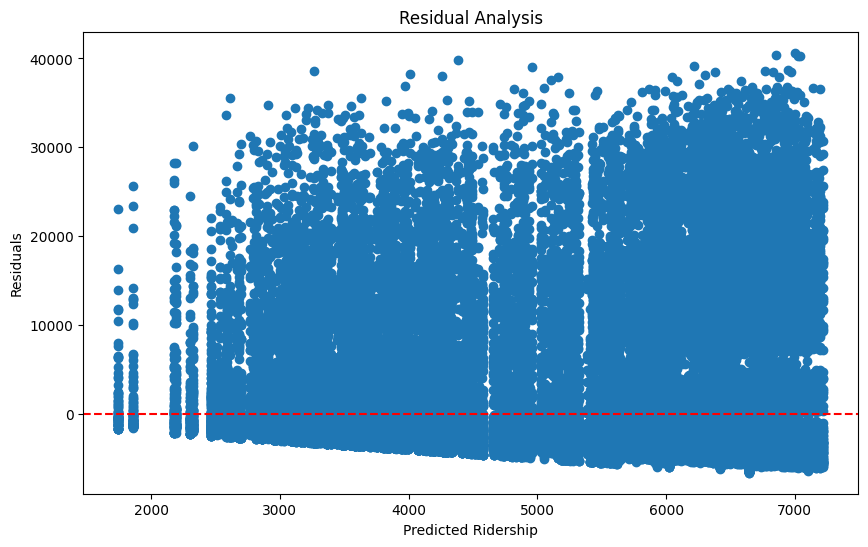

In [113]:
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Ridership')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.axhline(0, color='red', linestyle='--')
plt.show()


In [114]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=tscv,
    n_jobs=-1
)

grid_search.fit(X, y)
print('Best Parameters:', grid_search.best_params_)
print('Best MAE:', -grid_search.best_score_)


Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best MAE: 4073.617435159102


: 

: 

: 

: 

: 

: 

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Ridership')
plt.plot(y_pred, label='Predicted Ridership')
plt.legend()
plt.title('Actual vs. Predicted Ridership')
plt.show()


In [61]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Filter data for the station complex you want to visualize
station_complex_id = 59
station_complex_data = grouped_station_complex_hourly[grouped_station_complex_hourly['station_complex_id'] == station_complex_id]

# Get unique days for dropdown selection
unique_days = station_complex_data['day'].unique()

# Create a figure
fig = go.Figure()

# Create a plot for each day and add to the figure
for day in unique_days:
    day_data = station_complex_data[station_complex_data['day'] == day]
    fig.add_trace(
        go.Scatter(
            x=day_data['hour'],
            y=day_data['ridership'],
            mode='lines+markers',
            name=str(day)
        )
    )

# Update layout for dropdown to select dates
fig.update_layout(
    title=f'Hourly Ridership for Station Complex {station_complex_id}',
    xaxis_title='Hour of the Day',
    yaxis_title='Ridership',
    updatemenus=[
        {
            "buttons": [
                {
                    "method": "update",
                    "label": str(day),
                    "args": [{"visible": [day == unique_day for unique_day in unique_days]}],
                }
                for day in unique_days
            ],
            "direction": "down",
            "showactive": True,
        }
    ]
)

fig.show()



In [57]:
# check dates for complex 1 
station_complex_data['day'].unique()



array([datetime.date(2022, 3, 9), datetime.date(2022, 3, 16),
       datetime.date(2022, 3, 19), datetime.date(2022, 3, 29),
       datetime.date(2022, 4, 1), datetime.date(2022, 4, 3),
       datetime.date(2022, 4, 12), datetime.date(2022, 4, 15),
       datetime.date(2022, 4, 24), datetime.date(2022, 5, 10),
       datetime.date(2022, 5, 21), datetime.date(2022, 5, 22),
       datetime.date(2022, 5, 29), datetime.date(2022, 6, 6),
       datetime.date(2022, 6, 7), datetime.date(2022, 6, 11),
       datetime.date(2022, 7, 24), datetime.date(2022, 7, 27),
       datetime.date(2022, 8, 5), datetime.date(2022, 8, 10),
       datetime.date(2022, 8, 15), datetime.date(2022, 8, 17),
       datetime.date(2022, 9, 13), datetime.date(2022, 9, 19),
       datetime.date(2022, 9, 20), datetime.date(2022, 9, 24),
       datetime.date(2022, 9, 26), datetime.date(2022, 10, 15),
       datetime.date(2022, 10, 25), datetime.date(2022, 11, 9),
       datetime.date(2022, 11, 10), datetime.date(2022, 11,

In [43]:
# map data based on statoin complex id and lat long
station_data = hourly_ridership_data[['station_complex_id', 'station_complex', 'latitude', 'longitude']].drop_duplicates()

# scatter plot of station complex
fig = px.scatter_mapbox(
    station_data,
    lat='latitude',
    lon='longitude',
    hover_name='station_complex',
    hover_data=['station_complex_id'],
    zoom=10
)
# add plotly map layout
fig.update_layout(
    mapbox_style='carto-positron',
    margin={"r":0,"t":0,"l":0,"b":0}
)

fig.show()